In [1]:
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
import scipy.stats as stats
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

import sup_defs

What do we have here?

In [2]:
ab_data = pd.read_csv('ab_data.csv')
ab_data

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


No nulls found

In [3]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Groups differ in size, something is wrong here

In [4]:
ab_data['group'].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

The 'group' and 'landing_page' columns should be the same size, but have a different number of observations. This is a job for a ~witcher~ analyst

In [5]:
ab_data['landing_page'].value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

Four thousand messed up lines, that's a lot

In [6]:
ab_data['check_page'] = ab_data['landing_page'].replace({'old_page':'control', 
                                                         'new_page':'treatment'})
ab_data[ab_data['group'] != ab_data['check_page']]

,user_id,timestamp,group,landing_page,converted,check_page
22,767017,2017-01-12 22:58:14.991443,control,new_page,0,treatment
240,733976,2017-01-11 15:11:16.407599,control,new_page,0,treatment
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0,control
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0,control
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0,control
...,...,...,...,...,...,...
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0,control
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0,treatment
294252,892498,2017-01-22 01:11:10.463211,treatment,old_page,0,control
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0,treatment


Perhaps the problem is with the users. It needs to be checked

In [7]:
ab_data = ab_data.sort_values(by='timestamp')
ab_data['user_id'].value_counts()

710039    2
867226    2
911040    2
926754    2
870710    2
         ..
917311    1
930737    1
630252    1
913465    1
920411    1
Name: user_id, Length: 290584, dtype: int64

Very strange, the same page was shown to one user, but he was assigned to different groups. Another user was shown different pages but was assigned to the same group. If during A-B testing both options are shown to one user, he should belong to different groups, and if there is one option, then the group should be the same.

In [8]:
ab_data[ab_data['user_id'] == 805339]

,user_id,timestamp,group,landing_page,converted,check_page
90794,805339,2017-01-12 08:45:15.557052,treatment,old_page,0,control
234436,805339,2017-01-22 23:00:09.005288,control,old_page,0,control


In [9]:
ab_data[ab_data['user_id'] == 754884]

,user_id,timestamp,group,landing_page,converted,check_page
245524,754884,2017-01-17 23:46:45.624036,treatment,new_page,0,treatment
236842,754884,2017-01-18 20:10:48.538515,treatment,old_page,0,control


In [10]:
ab_data[ab_data['user_id'] == 722274]

,user_id,timestamp,group,landing_page,converted,check_page
262554,722274,2017-01-09 21:21:23.638444,control,new_page,0,treatment
105487,722274,2017-01-19 01:46:53.093257,control,old_page,0,control


If you remove all inconsistencies, all duplicate users disappear (except one)

In [11]:
ab_data_cl = ab_data[ab_data['group'] == ab_data['check_page']]
ab_data_cl['user_id'].value_counts()

773192    2
922696    1
829063    1
867327    1
762358    1
         ..
655980    1
861027    1
887897    1
924198    1
920411    1
Name: user_id, Length: 290584, dtype: int64

I think it's better to ignore this exception

In [12]:
ab_data_cl = ab_data_cl.drop_duplicates(subset='user_id', keep='first')
ab_data_cl['landing_page'].value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

In [13]:
ab_data_cl['group'].value_counts()

treatment    145310
control      145274
Name: group, dtype: int64

Columns now match

In [14]:
ab_data_cl[ab_data_cl['group'] != ab_data_cl['check_page']]

,user_id,timestamp,group,landing_page,converted,check_page


After processing the data, it is necessary to determine the number of observations sufficient to conduct the test. 

As always, we will test the null hypothesis H0, which states that there are no significant differences between the new and old designs. We will also test the alternative hypothesis H1, which states that there are still differencesare still differences

I see no need to break the "gold standard" and chose alpha = 0.05, power = 0.8. The proportion_effectsize function calculates the effect size for a test comparing two proportions. The conversion rate is currently 12%, with the new page we expect this to increase by 2%. We need 4433 observations for each group

In [15]:
prop_effsize = sms.proportion_effectsize(0.12, 0.14)
alpha = 0.05
power = 0.8

required_n = sms.NormalIndPower().solve_power(
    prop_effsize,  
    alpha=alpha,
    power=power
    )
required_n = ceil(required_n)
required_n

4433

The required number of observations was placed in a separate dataframe.

In [16]:
ab_required = pd.concat(
    [ab_data_cl[ab_data_cl['group'] == 'control'].head(required_n),
     ab_data_cl[ab_data_cl['group'] == 'treatment'].head(required_n)], ignore_index=True)

ab_required

,user_id,timestamp,group,landing_page,converted,check_page
0,781507,2017-01-02 13:42:15.234051,control,old_page,0,control
1,737319,2017-01-02 13:42:21.786186,control,old_page,0,control
2,799109,2017-01-02 13:42:45.219901,control,old_page,0,control
3,643921,2017-01-02 13:43:03.767329,control,old_page,1,control
4,677659,2017-01-02 13:43:32.744957,control,old_page,0,control
...,...,...,...,...,...,...
8861,816556,2017-01-03 05:39:04.377045,treatment,new_page,0,treatment
8862,706254,2017-01-03 05:39:46.805443,treatment,new_page,0,treatment
8863,872254,2017-01-03 05:40:18.166385,treatment,new_page,0,treatment
8864,832214,2017-01-03 05:40:27.946779,treatment,new_page,0,treatment


To evaluate the performance of a new page, we need to calculate the conversion, standard deviation, and standard error of the mean for each group. At this stage, the conclusion is that the new page is not more efficient than the old one.

In [17]:
std_dev = lambda x: np.std(x, ddof=0)
std_err = lambda x: stats.sem(x, ddof=0)

conv_rates = ab_required.groupby('group')['converted']
conv_rates = conv_rates.agg([np.mean, std_dev, std_err])

conv_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conv_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.324,0.005
treatment,0.117,0.321,0.005


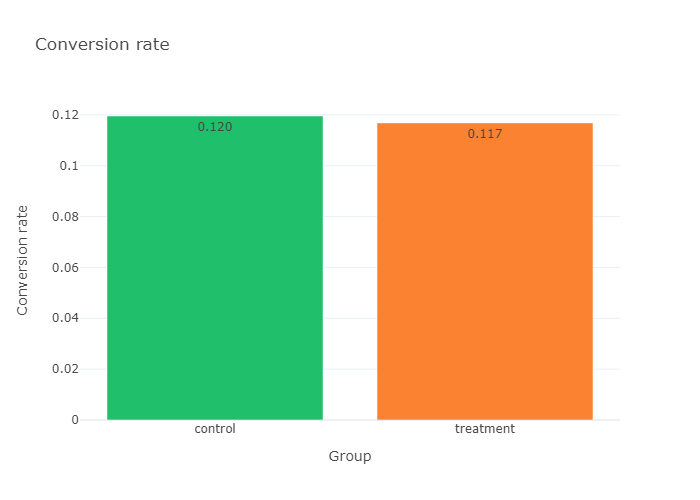

In [18]:
sup_defs.bar_plot(
    dataf=None, 
    x=conv_rates['conversion_rate'].index, 
    y=conv_rates['conversion_rate'].values,
    title='Conversion rate',
    x_label='Group',
    y_label='Conversion rate').show('png')

The sample size is large, so z-test will be used. The calculated p-value is much greater than 0.05, which means that the null hypothesis cannot be rejected. Interestingly, our theoretical estimate of 14% conversion on a new page is not even within the confidence interval.

In [19]:
g_counts = [ab_required[ab_required['group'] == 'control']['converted'].sum(), 
            ab_required[ab_required['group'] == 'treatment']['converted'].sum()]
nobs = [required_n, required_n]

z_stat, pval = proportions_ztest(
    g_counts, 
    nobs=nobs
    )
ci_low, ci_upp = proportion_confint(
    g_counts, 
    nobs=nobs, 
    alpha=alpha
    )
print(f'z statistic: {z_stat:.3f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% Control group: [{ci_low[0]:.3f}, {ci_upp[0]:.3f}]')
print(f'ci 95% Reatment group: [{ci_low[1]:.3f}, {ci_upp[1]:.3f}]')

z statistic: 0.395
p-value: 0.693
ci 95% Control group: [0.110, 0.129]
ci 95% Reatment group: [0.107, 0.126]
